Проект:

https://www.kaggle.com/c/regression-tutors-expected-math-exam-results регрессия
https://www.kaggle.com/c/classification-choose-tutors классификация

* [Балансировка.](#1)
* [Первая модель деревья решений.](#2)
* [Логистическая регрессия с log loss.](#3)
* [Стандартизация для второй модели.](#4)
* [Вторая версия 2 модели](#5)

In [121]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
train = pd.read_csv('~/Desktop/Proj/classification-choose-tutors/train.csv')
test = pd.read_csv('~/Desktop/Proj/classification-choose-tutors/test.csv')

In [123]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [124]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


<AxesSubplot:>

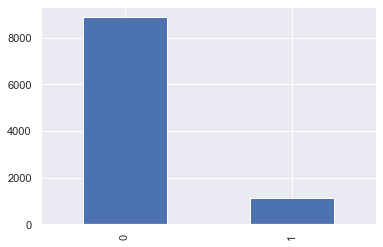

In [125]:
train['choose'].value_counts().plot.bar()

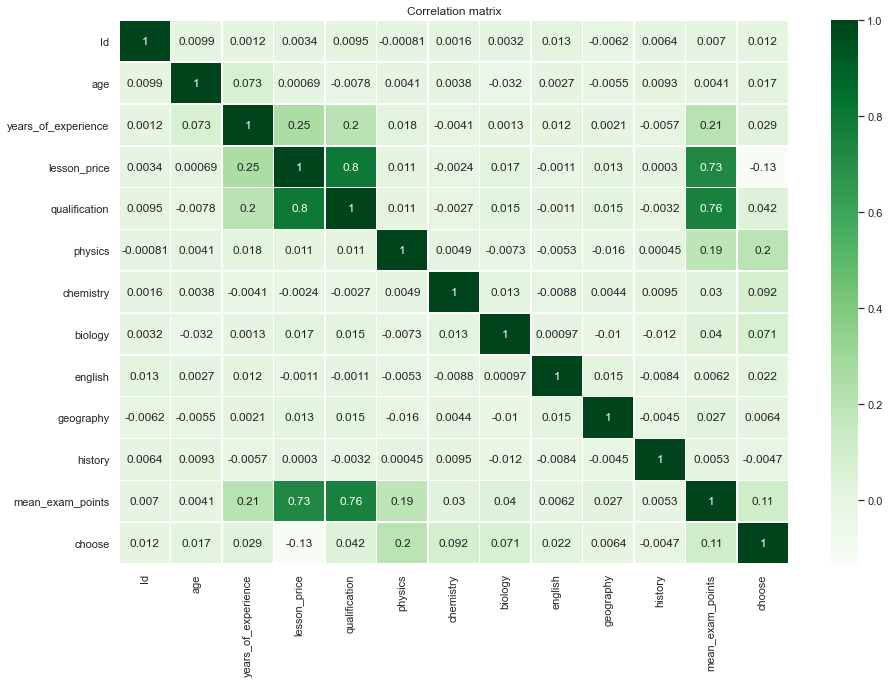

In [6]:
# тепловая карта корреляции
plt.figure(figsize = (15,10))

sns.set(font_scale=1)
sns.heatmap(train.corr(), annot=True, linewidths=.5, cmap='Greens')

plt.title('Correlation matrix')
plt.show()

In [126]:
# train_target - целевая переменная
train_target = train.choose
id_ = train.Id # ID потом concat
train_data = train.drop(['Id','choose'], axis = 1)

In [8]:
print(train_data.shape)
print(test.shape) # из-за ID

(10000, 11)
(10000, 12)


### Балансировка <a class='anchor' id='1'>

In [9]:
train_target.value_counts()

0    8891
1    1109
Name: choose, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=2, stratify=train_target)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.889125
1    0.110875
Name: choose, dtype: float64

0    0.889
1    0.111
Name: choose, dtype: float64

In [11]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

8.019165727170236

In [42]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    return df.sample(frac=1)

In [13]:
# train_df = pd.concat([pd.DataFrame(X_train), y_train], axis=1)
print(f'До oversampling:\n{train_target.value_counts()}')
over_df = balance_df_by_target(train, target_name='choose', method='over')
print(f'\nПосле oversampling:\n{over_df.choose.value_counts()}')

До oversampling:
0    8891
1    1109
Name: choose, dtype: int64

После oversampling:
0    8891
1    8872
Name: choose, dtype: int64


In [14]:
over_df

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
16253,7537,54.0,0.0,1300.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0,1
3647,3647,36.0,1.0,1600.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,59.0,0
10601,1028,41.0,3.0,1650.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,57.0,1
17371,8770,43.0,1.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,63.0,1
6859,6859,39.0,0.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11337,5941,55.0,0.0,1150.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,1
258,258,39.0,1.0,1750.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,76.0,1
14052,2189,48.0,4.0,1050.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,1
12804,1820,45.0,5.0,1550.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,1


In [15]:
train_target = over_df.choose
train_data_ = over_df.drop(['choose'], axis = 1)

In [16]:
train_data_

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
16253,7537,54.0,0.0,1300.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
3647,3647,36.0,1.0,1600.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,59.0
10601,1028,41.0,3.0,1650.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,57.0
17371,8770,43.0,1.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,63.0
6859,6859,39.0,0.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11337,5941,55.0,0.0,1150.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0
258,258,39.0,1.0,1750.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,76.0
14052,2189,48.0,4.0,1050.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0
12804,1820,45.0,5.0,1550.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0


In [17]:
train_target

16253    1
3647     0
10601    1
17371    1
6859     0
        ..
11337    1
258      1
14052    1
12804    1
10834    1
Name: choose, Length: 17763, dtype: int64

In [18]:
# второй split
X_train, X_test, y_train, y_test = train_test_split(train_data_, train_target, test_size=0.30, random_state=2, stratify=train_target)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.500563
1    0.499437
Name: choose, dtype: float64

0    0.500469
1    0.499531
Name: choose, dtype: float64

# Построим первую модель на основе алгоритма построения деревьев решений. <a class='anchor' id='2'>

In [99]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [100]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [101]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [102]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [103]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [104]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [105]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [106]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [107]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [108]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [109]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [110]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [111]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [112]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из 50 деревьев

In [113]:
%%time
n_trees = 50
my_forest_1 = random_forest(X_train.values, y_train.values, n_trees)

Wall time: 12min 54s


In [177]:
# test_data = test.drop('Id', axis=1)
# test_data.head(5)

In [114]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, X_train.values)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, X_test.values)

In [115]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train.values, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test.values, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 93.461
Точность случайного леса из 50 деревьев на тестовой выборке: 89.323


In [116]:
unique, counts = np.unique(train_answers, return_counts=True)
print(np.array([unique, counts]).T)

[[   0 5711]
 [   1 6723]]


In [117]:
unique, counts = np.unique(test_answers, return_counts=True)
print(np.array([unique, counts]).T)

[[   0 2310]
 [   1 3019]]


In [15]:
test_data = test
test_data

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
2,10002,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
3,10003,44.0,4.0,2950.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0
4,10004,38.0,3.0,1400.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19995,44.0,3.0,1850.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,68.0
9996,19996,45.0,3.0,2450.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,72.0
9997,19997,44.0,2.0,1250.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,63.0
9998,19998,51.0,5.0,1000.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,64.0


In [62]:
X_train

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
4352,4352,44.0,0.0,1250.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,53.0
1963,1963,41.0,1.0,1300.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,67.0
4918,4918,35.0,3.0,2750.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0
9712,9712,42.0,4.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0
7545,7545,39.0,5.0,2100.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2397,2397,41.0,4.0,1350.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,68.0
11028,7537,54.0,0.0,1300.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
1273,1273,53.0,4.0,1050.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,49.0
135,135,47.0,4.0,1850.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0


In [118]:
test_pred = tree_vote(my_forest_1, test_data.values)

In [119]:
y_pred = pd.DataFrame(data=test_pred, columns=['choose'], index=None)

In [120]:
y_pred.insert(0, 'Id', test.Id)

In [121]:
y_pred.to_csv('submission1.csv', index=False)

### Модель показала результат 0.90215. Лучший результат с 50 деревьями.

# Построим вторую модель логистической регрессии с функцией log loss. <a class='anchor' id='3'>

In [9]:
# train_target - целевая переменная
train_target = train.choose
train_data = train.drop(['Id','choose'], axis = 1)
test_data = test.drop('Id', axis = 1)

In [10]:
print(train_data.shape)
print(test.shape) # из-за ID
print(test_data.shape)

(10000, 11)
(10000, 12)
(10000, 11)


### Стандартизация для второй модели. <a class='anchor' id='4'>

In [11]:
def standard_scale(x):
    res = (x - x.mean()) / x.std()
    intercept = pd.DataFrame(np.ones(len(x)), columns=['intercept'])
    x.insert(0, 'intercept', intercept)
    return res

In [12]:
train_stand = standard_scale(train_data)
test_stand = standard_scale(test_data)

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [14]:
def calc_logloss_2(y, y_pred):
    for i in range(len(y_pred)):
        if y_pred[i] == 0:
            y_pred[i]+=1e-4
        if y_pred[i] == 1:
            y_pred[i]-=1e-4
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [15]:
def eval_model(X, y, iterations, eta=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    
    for i in range(iterations):
        z = np.dot(X, W)
        y_pred = sigmoid(z)
        err = calc_logloss_2(y, y_pred)
        
        dQ = 1/n * X.T @ (y_pred - y)
        W -= eta * dQ
        if i % (iterations / 10) == 0:
            print(i, W, err)
    return W

In [16]:
%%time
W = eval_model(train_stand.values, train_target.values, iterations=1000, eta=1e-1)

0 [ 0.49192214 -0.14137028  0.62185957  1.50009336 -0.22417867 -0.22832214
  1.56374004  0.75878905 -0.46442416  0.53634813 -0.4773426 ] 1.2649956052864395
100 [ 0.11554289 -0.015061   -0.33019385  0.73633956  0.30596397  0.09401382
  0.38241693  0.15021869 -0.06000172  0.08988335 -0.4274443 ] 0.7016748625063832
200 [ 0.03708314  0.05716975 -0.54018224  0.58778708  0.29270129  0.12195771
  0.13128419  0.04395492  0.00875483  0.0068093  -0.09359335] 0.6693639381868953
300 [ 0.02480626  0.07141372 -0.64535984  0.50362774  0.25273249  0.11841255
  0.10042328  0.03154764  0.01110014 -0.00280283  0.09921448] 0.6632617473199626
400 [ 0.0221732   0.07559679 -0.70153324  0.45324533  0.22856152  0.11475713
  0.09460835  0.02943508  0.00910796 -0.00440922  0.20952623] 0.6613437531741545
500 [ 0.02121319  0.07739243 -0.73206061  0.42286415  0.21487338  0.11259905
  0.09249671  0.02874573  0.00768501 -0.00496196  0.27292666] 0.6607152986093889
600 [ 0.02072679  0.07829982 -0.74875857  0.40448263  

In [30]:
def calc_pred(x):
    y_pred = np.exp(x) / (1 + np.exp(x))
    y_pred = [0 if x <= 0.63 else 1 for x in  y_pred]
    return y_pred

In [31]:
c = np.array(calc_pred(np.dot(train_stand,W)))
c

array([0, 1, 0, ..., 0, 0, 0])

In [32]:
unique, counts = np.unique(c, return_counts=True)
print(np.array([unique, counts]).T)

[[   0 8429]
 [   1 1571]]


In [33]:
y_pred_2 = np.array(calc_pred(np.dot(test_stand,W)))

In [34]:
y_pred_2 = pd.DataFrame(data=y_pred_2, columns=['choose'], index=None)

In [35]:
y_pred_2.insert(0, 'Id', test.Id)

In [36]:
y_pred_2.to_csv('submission2.csv', index=False)

In [37]:
unique, counts = np.unique(y_pred_2.choose, return_counts=True)
print(np.array([unique, counts]).T)

[[   0 8462]
 [   1 1538]]


In [39]:
unique, counts = np.unique(y_pred.choose, return_counts=True)
print(np.array([unique, counts]).T)

[[   0 7970]
 [   1 2030]]


In [40]:
# количество ращличий между предскзаниями
sum(y_pred.choose != y_pred_2.choose)

1264

### Модель показала результат 0.92791.

# Вторая версия 2 модели <a class='anchor' id='5'>

In [129]:
# train_target - целевая переменная
train_target = train.choose
train_data = train.drop(['Id','choose'], axis = 1)
test_data = test.drop('Id', axis = 1)

In [130]:
print(train_data.shape)
print(test.shape) # из-за ID
print(test_data.shape)

(10000, 11)
(10000, 12)
(10000, 11)


### Редактированная стандартизация

In [131]:
means = np.mean(train_data[['age', 'years_of_experience', 'lesson_price', 'qualification', 'mean_exam_points']])
stds = np.std(train_data[['age', 'years_of_experience', 'lesson_price', 'qualification', 'mean_exam_points']])
display(means, stds)

age                      45.8009
years_of_experience       1.9748
lesson_price           1702.4400
qualification             1.7243
mean_exam_points         64.4352
dtype: float64

age                      8.029873
years_of_experience      1.766795
lesson_price           523.762872
qualification            0.798805
mean_exam_points        13.594344
dtype: float64

In [132]:
def standard_scale(X, means, stds):
    X_ = X[['age', 'years_of_experience', 'lesson_price', 'qualification', 'mean_exam_points']].copy()
    X_ = (X_-means)/stds
    X_ = pd.concat([X_, X[['physics', 'chemistry', 'biology', 'english', 'geography', 'history']]], axis=1)
    intercept = pd.DataFrame(np.ones(len(X)), columns=['intercept'])
    X_.insert(0, 'intercept', intercept)
    return X_

In [133]:
train_stand = standard_scale(train_data, means, stds)
test_stand = standard_scale(test_data, means, stds)

In [134]:
train_stand.head(3)

,intercept,age,years_of_experience,lesson_price,qualification,mean_exam_points,physics,chemistry,biology,english,geography,history
0,1.0,-1.345090,-1.117730,0.854509,0.345141,0.703587,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.772005,0.014263,-0.863826,0.345141,-0.546933,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,-2.092300,0.580260,0.090804,-0.906729,0.115107,1.0,0.0,0.0,0.0,0.0,0.0


In [135]:
test_stand.head(3)

,intercept,age,years_of_experience,lesson_price,qualification,mean_exam_points,physics,chemistry,biology,english,geography,history
0,1.0,-1.718695,0.014263,1.904602,1.597010,1.880547,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-1.345090,2.278249,0.186267,0.345141,0.482907,1.0,1.0,0.0,0.0,0.0,0.0
2,1.0,-0.224275,0.014263,-0.959289,-0.906729,-1.429653,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [137]:
def calc_logloss_2(y, y_pred):
    for i in range(len(y_pred)):
        if y_pred[i] == 0:
            y_pred[i]+=1e-4
        if y_pred[i] == 1:
            y_pred[i]-=1e-4
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [138]:
def eval_model(X, y, iterations, eta=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    
    for i in range(iterations):
        z = np.dot(X, W)
        y_pred = sigmoid(z)
        err = calc_logloss_2(y, y_pred)
        
        dQ = 1/n * X.T @ (y_pred - y)
        W -= eta * dQ
        if i % (iterations / 10) == 0:
            print(i, W, err)
    return W

In [13]:
%%time
W = eval_model(train_stand.values, train_target.values, iterations=1000, eta=1e-1)

0 [ 0.44094767 -0.13581111  0.63672842  1.50190461 -0.24525941 -0.24326741
  1.55568562  0.76037098 -0.47462767  0.53898459 -0.46472752 -0.46660844] 1.5184749112625195
100 [-1.84239427 -0.01670262  0.10182486  0.41221893 -0.30292309 -0.15515072
  0.64158775  0.47176398 -0.57357775  0.37755701 -0.50131628 -0.49578293] 0.384039216806899
200 [-2.1961322   0.01677884  0.07651296 -0.0512524  -0.1102779   0.13924812
  0.62104167  0.45742533 -0.48503147  0.34710906 -0.49381036 -0.49553628] 0.3336142611971681
300 [-2.33737567  0.03079983  0.08410944 -0.40636403  0.04096745  0.34974403
  0.66967295  0.47251725 -0.38854155  0.33334531 -0.48289383 -0.49259796] 0.31080095441154165
400 [-2.43714581  0.0364086   0.08769298 -0.6905757   0.16815529  0.50815229
  0.71165217  0.49057809 -0.29802214  0.32339651 -0.47169503 -0.48916971] 0.2964452775808027
500 [-2.52387383  0.03870247  0.0850708  -0.92269552  0.27674439  0.63163559
  0.74130907  0.50786252 -0.21536076  0.31508851 -0.46066529 -0.48561656] 0

In [14]:
def calc_pred(x):
    y_pred = np.exp(x) / (1 + np.exp(x))
    y_pred = [0 if x <= 0.262 else 1 for x in  y_pred]
    return y_pred

In [15]:
c = np.array(calc_pred(np.dot(train_stand,W)))
c

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
unique, counts = np.unique(c, return_counts=True)
print(np.array([unique, counts]).T)

[[   0 8984]
 [   1 1016]]


In [25]:
y_pred_3 = np.array(calc_pred(np.dot(test_stand,W)))

In [26]:
y_pred_3 = pd.DataFrame(data=y_pred_2, columns=['choose'], index=None)

In [27]:
y_pred_3.insert(0, 'Id', test.Id)

In [28]:
y_pred_3.to_csv('submission30.csv', index=False)

In [29]:
unique, counts = np.unique(y_pred_3.choose, return_counts=True)
print(np.array([unique, counts]).T)

[[   0 9012]
 [   1  988]]


In [30]:
y_pred = pd.read_csv('~/Desktop/Proj/classification-choose-tutors/submission1.csv')

In [31]:
unique, counts = np.unique(y_pred.choose, return_counts=True)
print(np.array([unique, counts]).T)

[[   0 7970]
 [   1 2030]]


In [32]:
# количество ращличий между предскзаниями
sum(y_pred.choose != y_pred_2.choose)

1338

### Модель показала результат 0.95002.

# Третья модель на основании алгоритма KNN

In [166]:
print(f'До oversampling:\n{train_target.value_counts()}')
over_df = balance_df_by_target(train, target_name='choose', method='over')
print(f'\nПосле oversampling:\n{over_df.choose.value_counts()}')

До oversampling:
0    8891
1    8872
Name: choose, dtype: int64

После oversampling:
0    8891
1    8872
Name: choose, dtype: int64


In [167]:
train_target = over_df.choose
train_data_ = over_df.drop(['choose'], axis = 1)

In [170]:
train_data_2 = train_data_.drop('Id', axis = 1)
test_data = test.drop('Id', axis = 1)

In [100]:
# test_data = test.drop(['Id'], axis = 1)

In [174]:
X_train, X_test, y_train, y_test = train_test_split(train_data_2.values, train_target.values, 
                                                    test_size=0.3, random_state=9, stratify=train_target.values)

In [182]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
        
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [261]:
# ноль циклов
def knn(x_train, y_train, x_test, k, weights=None):
    
    # расчет расстояний от классифицируемых объектов до
    # объектов обучающей выборки
    distances = np.sqrt(np.sum(np.square(x_test[:, np.newaxis] - x_train), axis=2))
                
    answers = []    
    for distance in distances:
        # Записываем в список значение расстояния и ответа на объекте обучающей выборки
        test_distances = [(dist, label) for dist, label in zip(distance, y_train)]
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            #w = 1/(d[0] + 1)
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [185]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [186]:
k = 3

%time y_pred_train = knn(X_train, y_train, X_train, k)
%time y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {accuracy(y_pred, y_test):.3f}')

Wall time: 3min 7s
Wall time: 1min 11s
Точность алгоритма на трейне при k = 3: 0.993
Точность алгоритма на тесте при k = 3: 0.914


In [262]:
%time y_pred_4 = knn(train_data_2.values, train_target.values, test_data.values, 15)

Wall time: 3min 55s


In [263]:
y_pred_4 = pd.DataFrame(data=y_pred_4, columns=['choose'], index=None)

In [264]:
y_pred_4.insert(0, 'Id', test.Id)

In [265]:
y_pred_4.to_csv('submissionKNN.csv', index=False)

In [266]:
unique, counts = np.unique(y_pred_4.choose, return_counts=True)
print(np.array([unique, counts]).T)

[[   0 6760]
 [   1 3240]]


In [267]:
y_pred = pd.read_csv('~/Desktop/Proj/classification-choose-tutors/submission30.csv')

In [268]:
unique, counts = np.unique(y_pred.choose, return_counts=True)
print(np.array([unique, counts]).T)

[[   0 9012]
 [   1  988]]


In [269]:
# количество ращличий между предскзаниями
sum(y_pred.choose != y_pred_4.choose)

2640

### Модель показала результат 0.84790. Слишком большая разница в ответах между предсказанием с наилучшими результатми, а разница в скоре не большая. Например, что 1500 примерно 1 класса, что 3200 дают на Kaggle score 0.84 и 0.85. Тогда по идее на private только будет видно, как правильнее. На train и test проверке, вообще результат не совпал с test. Как улучшить алгоритм?

# Как вообще в общем score увеличить?